## MNIST Image Classification with an MLP Model

### Build the dataset and dataloader

In [1]:
# Einops library import
from einops import rearrange, repeat, reduce

In [2]:
import torch
import torchvision
from torchvision import transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Visualize samples from the dataset

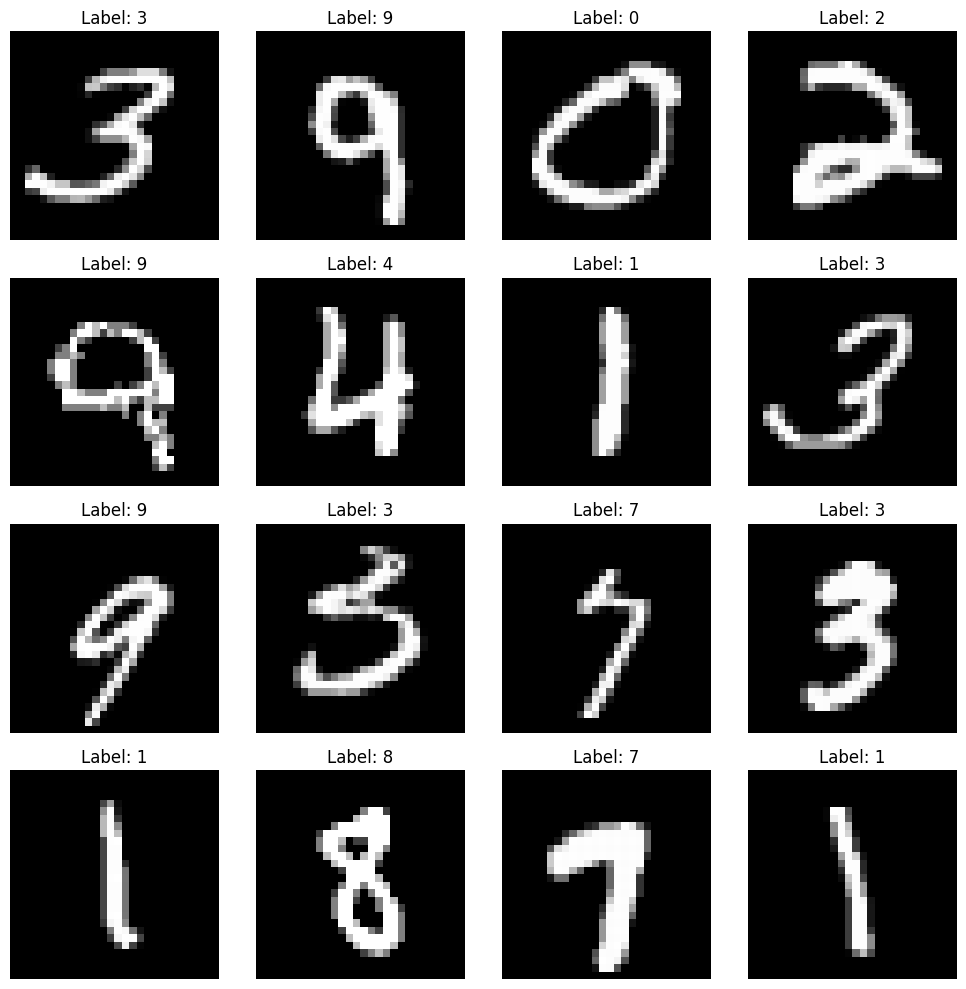

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get 16 random indices
indices = np.random.choice(len(train_dataset), size=16, replace=False)

# Get the corresponding images and labels
images = [train_dataset[i][0] for i in indices]
labels = [train_dataset[i][1] for i in indices]

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Iterate over the subplots and display the images with labels
for i, ax in enumerate(axes.flat):
    img = reduce(images[i], "c h w -> h w", 'mean') 
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


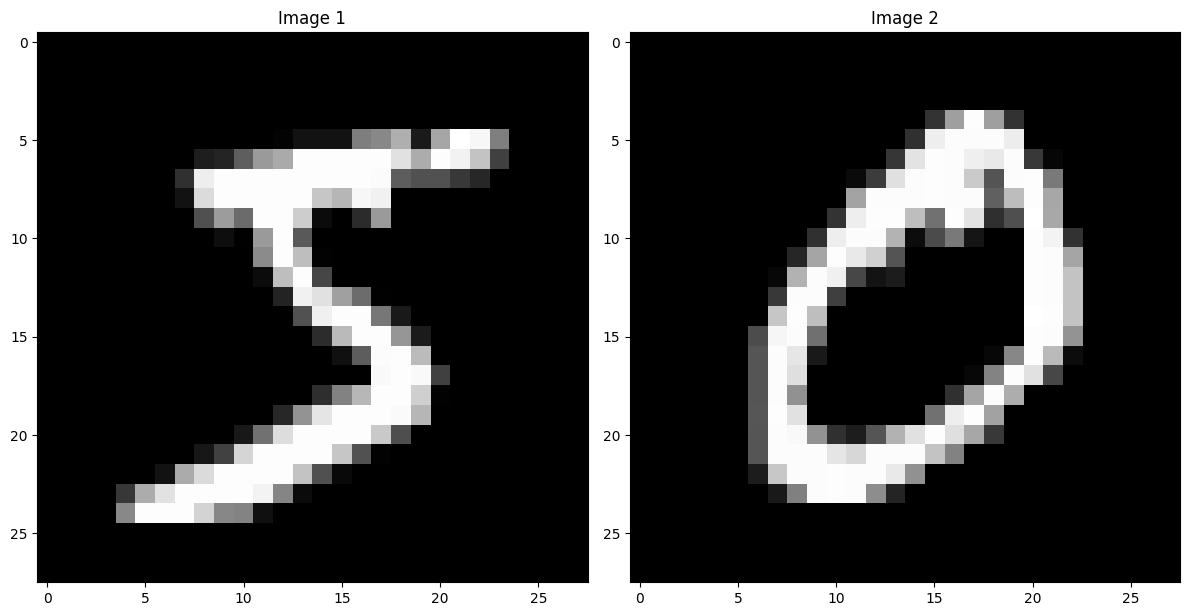

In [5]:
from einops import reduce, rearrange, repeat
import matplotlib.pyplot as plt
singe_image = train_dataset[0][0]
img_1 = train_dataset[0][0]
img_2 = train_dataset[1][0]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(reduce(img_1, "c h w -> h w", 'mean'), cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(reduce(img_2, "c h w -> h w", 'mean'), cmap='gray')
plt.title('Image 2')


plt.tight_layout()
plt.show()





In [18]:

combined_img = torch.cat((img_1, img_2), dim=2)  # Concatenate along width

In [19]:
combined_img.shape

torch.Size([1, 28, 56])

In [24]:

combined_img = reduce(combined_img, "c h w -> h w", 'mean')
combined_img.shape

torch.Size([28, 56])

In [27]:
import numpy as np

a = np.array([[[1, 2], [3, 4]],[[1, 100], [3, 4]]])
b = np.array([[10, 20], [30, 40]])

result = a * b
print(result)
# Output:
# [[ 10  40]
#  [ 90 160]]

[[[  10   40]
  [  90  160]]

 [[  10 2000]
  [  90  160]]]


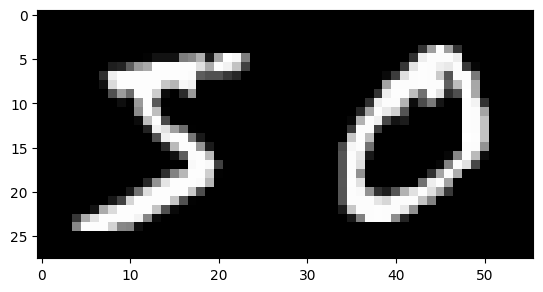

In [ ]:



plt.imshow(reduce(combined_img, "c h w -> h w", 'mean'), cmap='gray')

### Build an MLP Model

In [13]:
import torch
import torch.nn as nn

# Creating custom Linear and ReLU layers using nn.Module, that use einops in their forward methods
class CustomLinearActivation(nn.Module):
    def __init__(self,  
        in_features: int,
        out_features: int,
        bias: bool = True,):
        # factory_kwargs = {"device": device, };
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None

    def forward(self, x):
        # x shape: (batch, in_features)
        # x: (batch, in_features)
        # self.weight: (out_features, in_features)
        # Goal: out = x @ self.weight.t() + bias

        # Rearrange weight to (in_features, out_features)
        weight_t = rearrange(self.weight, 'o i -> i o')
        # Perform batched matrix multiplication using einops.reduce
        out = reduce(
            rearrange(x, 'b i -> b i 1') * rearrange(weight_t, 'i o -> 1 i o'),
            'b i o -> b o', 'sum'
        )
        if self.bias is not None:
            # Expand bias to match out shape using einops
            out = out + self.bias
        return out

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, "

class CustomReluActivation(nn.Module):
    def __init__(self, inplace: bool = False):
        super().__init__()
        self.inplace = inplace

    def forward(self, x):
         # x shape: (batch, in_features)
        return rearrange(x, '... -> ...').clamp(min=0)
    
    def extra_repr(self) -> str:
        inplace_str = "inplace=True" if self.inplace else ""
        return inplace_str

class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = CustomLinearActivation(input_size, hidden_size)
        self.relu = CustomReluActivation()
        self.fc2 = CustomLinearActivation(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        
        return y

# Create an instance of the MLP model
model = MLP()
x = torch.randn(64, 1, 28, 28)
print(model)
print(model(x).shape)

# print the number of parameters
num_params = sum(p.numel() for p in model.parameters())
# Use comma to print the number in a more readable format
print(f"Number of parameters: {num_params:,}")

MLP(
  (fc1): CustomLinearActivation(in_features=784, out_features=128, )
  (relu): CustomReluActivation()
  (fc2): CustomLinearActivation(in_features=128, out_features=10, )
)
torch.Size([64, 10])
Number of parameters: 101,770


### Define the loss function and optimizer

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [15]:
from tqdm import tqdm

num_epochs = 10

model.train()
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:07<01:03,  7.05s/it]

Epoch: 1, Loss: 0.4191


 20%|██        | 2/10 [00:14<00:56,  7.02s/it]

Epoch: 2, Loss: 0.2024


 30%|███       | 3/10 [00:22<00:54,  7.74s/it]

Epoch: 3, Loss: 0.1440


 40%|████      | 4/10 [00:31<00:49,  8.19s/it]

Epoch: 4, Loss: 0.1150


 50%|█████     | 5/10 [00:40<00:41,  8.40s/it]

Epoch: 5, Loss: 0.0986


 60%|██████    | 6/10 [00:49<00:34,  8.57s/it]

Epoch: 6, Loss: 0.0869


 70%|███████   | 7/10 [01:30<00:57, 19.24s/it]

Epoch: 7, Loss: 0.0775


 80%|████████  | 8/10 [02:40<01:11, 35.52s/it]

Epoch: 8, Loss: 0.0697


 90%|█████████ | 9/10 [03:51<00:46, 46.48s/it]

Epoch: 9, Loss: 0.0628


100%|██████████| 10/10 [04:52<00:00, 29.24s/it]

Epoch: 10, Loss: 0.0576


### Evaluate the model

In [16]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9721


### Predict on sample images

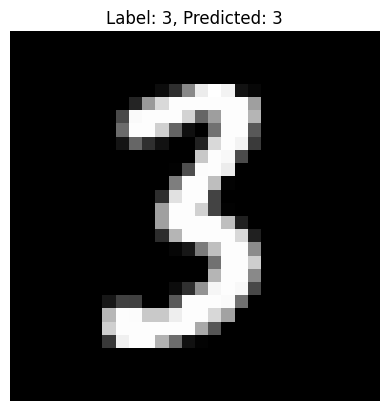

In [17]:
import random

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Move the image to the device
image = image.to(device)

# Forward pass to get the predicted label
output = model(image.unsqueeze(0))
_, predicted_label = torch.max(output, 1)

# Convert the image tensor to a numpy array
image_np = image.cpu().numpy()

# Display the image, its label, and the predicted label
plt.imshow(image_np.squeeze(), cmap='gray')
plt.title(f"Label: {label}, Predicted: {predicted_label.item()}")
plt.axis('off')
plt.show()
